In [1]:
import sys, os
sys.path.append('..')
import PPILinkPred as ppiLPred
import traversalHelper as tr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from collections import defaultdict
import math
import random as rand
from statistics import median
from statistics import mean
import multiprocessing
from multiprocessing import Pool, Manager
from functools import partial
import simulation as sim
import json
import pickle
from scipy.signal import savgol_filter
import seaborn as sns
from sklearn import metrics
import pandas as pd
from scipy import stats

# init metadata

In [2]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E1_f1Alt": "navy",
    "L3E1_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E1_f1Alt", "L3E1_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E1_f1Alt", "L3E1_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of\n $P_{4}$'s", "L3E'\n($f_{1}$)", "L3E'\n($f_{2}$)", "L3E\n($f_{1}$)", "L3E\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$'s", "L3E'($f_{1}$)", "L3E'($f_{2}$)", "L3E($f_{1}$)", "L3E($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

In [4]:
def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

In [ ]:
'''
init_graph_map = {
    "cn_graph": init_graph.cn_graph,
    "ideal_L3_graph": init_graph.ideal_L3_graph,
    "simple_L3_graph": init_graph.simple_L3_graph
}

mod_graph_map = {
    "removeComp_idealL3": mod_graph.removeComp_idealL3,
    "addComp_simpleL3": mod_graph.addComp_simpleL3,
    "addIncompA": mod_graph.addIncompA,
    "addIncompB": mod_graph.addIncompB,
    "addIncompC": mod_graph.addIncompC
    }
'''

In [5]:
def plotting(filename):
    with open(filename, "rb") as f:
        scores = pickle.loads(f.read())
    methods = list(scores.keys())
    alignedScores = defaultdict(dict)
    for method in methods:
        for trial in (len(scores[method])):
            scores[method][trial] = [0 if math.isnan(x) else x for x in scores[method][trial]]

        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = upperScores
        alignedScores[method]['lowerScores'] = lowerScores
        alignedScores[method]['medianScores'] = medianScores
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]

    fig, ax = plt.subplots(figsize=(5,3.2))
    for method in methods:
        method = methods_names[method]
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method]
            , alpha=0.3)
        if "Alt" in method:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=method, linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=method)

    plt.show()

# compatible edges

In [10]:
# experiments: 10 trials, 50 paths, sample until fulfilled
graphSize, saturateRatio = 50, 1
methods = ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "L3E1_f1Alt", "L3E1_f2Alt", 'countP4']
scores = defaultdict(list)
for method in methods:
    scores[method] = sim.simulation(method=method, graphSize=graphSize, saturateRatio=saturateRatio,
    graph_func="ideal_L3_graph", simulating="removeComp_idealL3", coreNo=5, trials=10)

with open("./simulation_out/compEdges.dat", "wb") as f:
    f.write(pickle.dumps(scores))

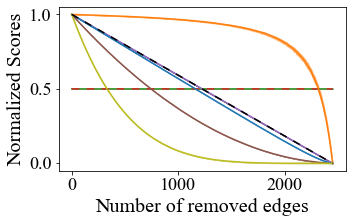

In [6]:
def plotting_scores(scores):
    alignedScores = defaultdict(dict)
    for method in methods:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]

    fig, ax = plt.subplots(figsize=(5,3.2))
    for method in methods:
        method = methods_names[method]
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method]
            , alpha=0.5)
        if method == "CRA" or method == "countP4":
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method])
    
    ax.set_ylabel("Normalized Scores")
    ax.set_xlabel("Number of removed edges")
    plt.tight_layout()
    plt.savefig('./img_simulation/compEdge_line.png', dpi=300)
    plt.show()
    
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())
    
methods = ['commonNeighbor', 'CRA', 'L3Normalizing', 'Sim', 'CH2_L3', 'L3E1_f1', 'L3E1_f2', 'countP4']
scores_alt = {}
for method in methods:
    if method in ['commonNeighbor', 'CRA']:
        scores[method] = [[0.5 for i in trial] for trial in scores[method]]
    scores_alt[method] = scores[method]
plotting_scores(scores_alt)

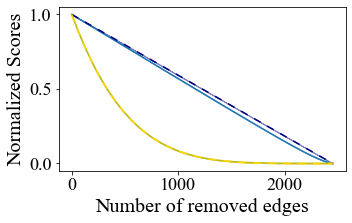

In [11]:
def plotting_scores(scores):
    alignedScores = defaultdict(dict)
    for method in methods:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]

    fig, ax = plt.subplots(figsize=(5,3.2))
    for method in methods:
        method = methods_names[method]
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method]
            , alpha=0.5)
        if method == "CRA" or method == "countP4" or "Alt" in method:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method])
    
    ax.set_ylabel("Normalized Scores")
    ax.set_xlabel("Number of removed edges")
    plt.tight_layout()
    plt.savefig('./img_simulation/compEdge_line_supple.png', dpi=300)
    plt.show()
    
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())

methods = ['L3E1_f1', 'L3E1_f2', "L3E1_f1Alt", "L3E1_f2Alt"]
scores_alt = {}
for method in methods: scores_alt[method] = scores[method]
plotting_scores(scores_alt)

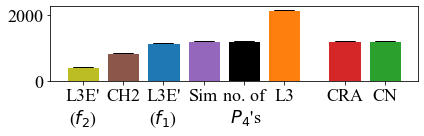

In [12]:
# calculate AUC
def AUC_plot(auc_map):
    mean_auc, std_auc = {}, {}
    for method in auc_map:
        mean_auc[method] = np.mean(auc_map[method])
        std_auc[method] = np.std(auc_map[method])
    
    pos = [0,1,2,3,4,5,6.5,7.5]
    fig = plt.figure(figsize=(6, 2))
    xtick = [i for i in list(dict(sorted(
        auc_map.items(), key=lambda item: item[1])).keys()) if i not in ['CN', 'CRA']] + ['CRA', 'CN']
    ax = plt.gca()
    ax.bar(pos, [mean_auc[x] for x in xtick], tick_label=[abbrevs[x] for x in xtick]
                      , yerr=[std_auc[x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='white', capsize=10)
    plt.tight_layout()
    plt.savefig('./img_simulation/compEdge_AUC.png', dpi=300)
    plt.show()
    
scores = {}
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())
    
for method in ['commonNeighbor', 'CRA']:
    scores[method] = [[0.5 for i in trial] for trial in scores[method]]
    
auc_map = defaultdict(list)
for method in ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "countP4"]:
    for trial in range(len(scores[method])):
        scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        smoothed_score = savgol_filter(scores[method][trial], 21, 3)
        x = [i for i in range(len(smoothed_score))]
        auc_map[methods_names[method]].append(metrics.auc(x, smoothed_score))
    
AUC_plot(auc_map)

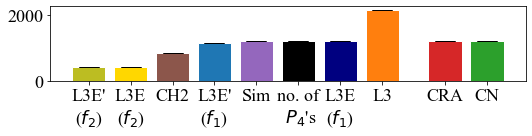

In [13]:
# calculate AUC
def AUC_plot(auc_map):
    mean_auc, std_auc = {}, {}
    for method in auc_map:
        mean_auc[method] = np.mean(auc_map[method])
        std_auc[method] = np.std(auc_map[method])
    
    pos = [0,1,2,3,4,5,6,7,8.5,9.5]
    fig = plt.figure(figsize=(7.5, 2))
    xtick = [i for i in list(dict(sorted(
        auc_map.items(), key=lambda item: item[1])).keys()) if i not in ['CN', 'CRA']] + ['CRA', 'CN']
    ax = plt.gca()
    ax.bar(pos, [mean_auc[x] for x in xtick], tick_label=[abbrevs[x] for x in xtick]
                      , yerr=[std_auc[x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='white', capsize=10)
    plt.tight_layout()
    plt.savefig('./img_simulation/compEdge_AUC_supple.png', dpi=300)
    plt.show()
    
scores = {}
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())
    
for method in ['commonNeighbor', 'CRA']:
    scores[method] = [[0.5 for i in trial] for trial in scores[method]]
    
auc_map = defaultdict(list)
for method in ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "countP4", "L3E1_f1Alt", "L3E1_f2Alt"]:
    for trial in range(len(scores[method])):
        scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        smoothed_score = savgol_filter(scores[method][trial], 21, 3)
        x = [i for i in range(len(smoothed_score))]
        auc_map[methods_names[method]].append(metrics.auc(x, smoothed_score))
    
AUC_plot(auc_map)

In [14]:
# p val
pairs = ['L3E1_f2', 'CH2']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

pairs = ['L3E1_f2', 'L3E1_f2Alt']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

pairs = ['L3E1_f1', 'L3E1_f1Alt']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

L3E1_f2 CH2: 4.677908631188083e-72
L3E1_f2 L3E1_f2Alt: 0.8368453713311126
L3E1_f1 L3E1_f1Alt: 6.181862274384656e-72


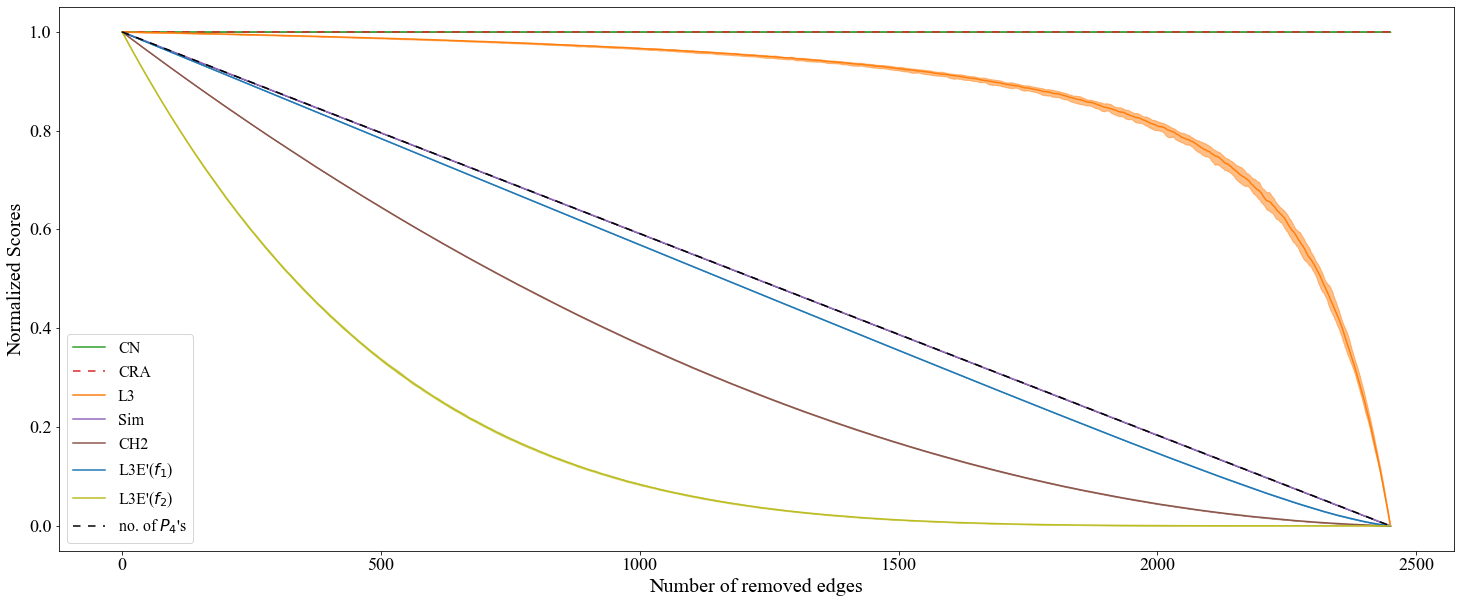

In [10]:
def plotting_scores(scores):
    alignedScores = defaultdict(dict)
    for method in methods:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]

    fig, ax = plt.subplots(figsize=(25,10))
    for method in methods:
        method = methods_names[method]
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method]
            , alpha=0.5)
        if method == "CRA" or method == "countP4" or "Alt" in method:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method])
    
    ax.set_ylabel("Normalized Scores")
    ax.set_xlabel("Number of removed edges")
    plt.legend()
    plt.savefig('./img_simulation/compEdge_legend.png', dpi=300)
    plt.show()
    
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())

methods = ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "countP4"]
scores_alt = {}
for method in methods: scores_alt[method] = scores[method]
plotting_scores(scores_alt)

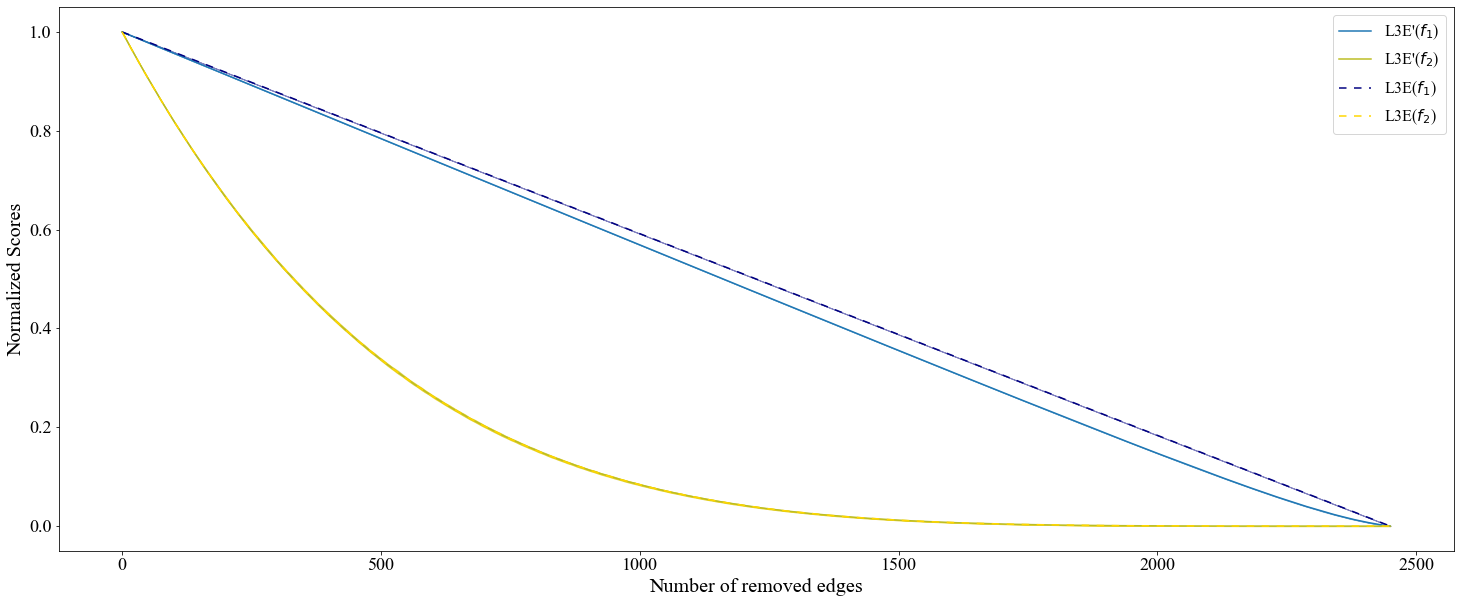

In [15]:
def plotting_scores(scores):
    alignedScores = defaultdict(dict)
    for method in methods:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]

    fig, ax = plt.subplots(figsize=(25,10))
    for method in methods:
        method = methods_names[method]
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method]
            , alpha=0.5)
        if method == "CRA" or method == "countP4" or "Alt" in method:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method])
    
    ax.set_ylabel("Normalized Scores")
    ax.set_xlabel("Number of removed edges")
    plt.legend()
    plt.savefig('./img_simulation/compEdge_legend.png', dpi=300)
    plt.show()
    
filename = "./simulation_out/compEdges.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())

methods = ["L3E1_f1", "L3E1_f2", "L3E1_f1Alt", "L3E1_f2Alt"]
scores_alt = {}
for method in methods: scores_alt[method] = scores[method]
plotting_scores(scores_alt)

# incompatible edges 1

In [16]:
# experiments: 10 trials, 50 paths, sample until fulfilled
graphSize, saturateRatio = 50, 1
methods = ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "L3E1_f1Alt", "L3E1_f2Alt", "countP4"]
scores = defaultdict(list)
for method in methods:
    scores[method] = sim.simulation(method=method, graphSize=graphSize, saturateRatio=1,
    graph_func="ideal_L3_graph", simulating="addIncompA", coreNo=5, trials=10)

with open("./simulation_out/incompEdges1.dat", "wb") as f:
    f.write(pickle.dumps(scores))

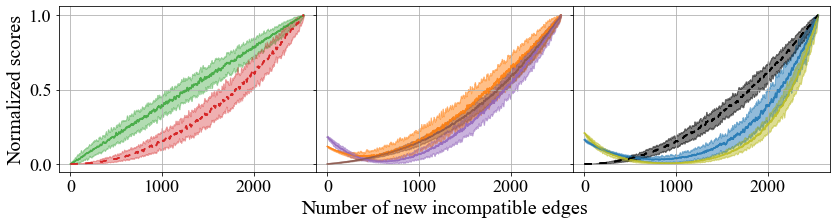

In [8]:
def aligning_scores(scores):
    alignedScores = defaultdict(dict)
    for method in scores:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]
    return alignedScores

def plotting_sns(ax, alignedScores):
    for method in alignedScores:
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method], alpha=0.2)
        if method == "CRA" or method == "countP4":
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], alpha=0.5)

        
filename = "./simulation_out/incompEdges1.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())

alignedScores = aligning_scores(scores)
tmp_df = pd.DataFrame({"type": ["CN", "L3", "L3E"]})
#sns.set_style("white")
g = sns.FacetGrid(tmp_df, col="type", margin_titles=True, despine=False, aspect=1.3)
axes = []
for (row_val), ax in g.axes_dict.items():
    axes.append(ax)
    if row_val == "CN": methods = ['CN', 'CRA']
    elif row_val == "L3": methods = ["L3", "Sim", "CH2"]
    elif row_val == "L3E": methods = ["L3E1_f1", "L3E1_f2", "countP4"]
    alignedScores_alt = {}
    for method in methods: alignedScores_alt[method] = alignedScores[method]
    for method in methods: plotting_sns(ax, alignedScores_alt)
    ax.grid()

axes[0].set_ylabel('Normalized scores')
axes[1].set_xlabel("Number of new incompatible edges")
g.fig.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
#g.savefig('./img_simulation/incompEdge.png', dpi=300)
plt.show()

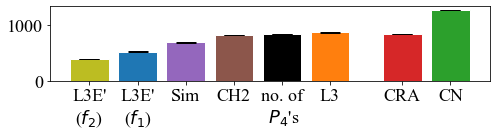

In [12]:
# calculate AUC
def AUC_plot(auc_map):
    mean_auc, std_auc = {}, {}
    for method in auc_map:
        mean_auc[method] = np.mean(auc_map[method])
        std_auc[method] = np.std(auc_map[method])
    
    pos = [0,1,2,3,4,5,6.5,7.5]
    fig = plt.figure(figsize=(7, 2))
    xtick = [i for i in list(dict(sorted(
        auc_map.items(), key=lambda item: item[1])).keys()) if i not in ['CN', 'CRA']] + ['CRA', 'CN']
    ax = plt.gca()
    ax.bar(pos, [mean_auc[x] for x in xtick], tick_label=[abbrevs[x] for x in xtick]
                      , yerr=[std_auc[x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='white', capsize=10)
    plt.tight_layout()
    plt.savefig('./img_simulation/incomp_AUC.png', dpi=300)
    plt.show()
    
scores = {}
filename = "./simulation_out/incompEdges1.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())
    
auc_map = defaultdict(list)
for method in ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "countP4"]:
    for trial in range(len(scores[method])):
        scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        smoothed_score = savgol_filter(scores[method][trial], 21, 3)
        x = [i for i in range(len(smoothed_score))]
        minX = np.argmin(np.asarray(smoothed_score))
        auc_map[methods_names[method]].append(metrics.auc(x[minX:], smoothed_score[minX:]))
    
AUC_plot(auc_map)

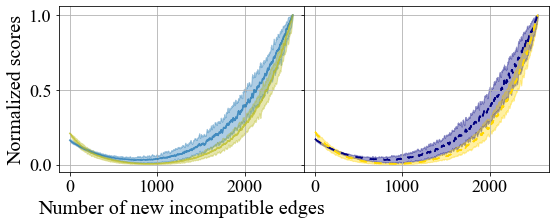

In [7]:
def aligning_scores(scores):
    alignedScores = defaultdict(dict)
    for method in scores:
        for trial in range(len(scores[method])):
            scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        
        upperScores, lowerScores, medianScores = get_plots_outline(scores[method], max), get_plots_outline(scores[method], min), get_plots_outline(scores[method], median)
        method = methods_names[method]
        alignedScores[method]['upperScores'] = savgol_filter(upperScores, 21, 3)
        alignedScores[method]['lowerScores'] = savgol_filter(lowerScores, 21, 3)
        alignedScores[method]['medianScores'] = savgol_filter(medianScores, 21, 3)
        alignedScores[method]['baseX'] = [i for i in range(len(upperScores))]
    return alignedScores

def plotting_sns(ax, alignedScores):
    for method in alignedScores:
        ax.fill_between(alignedScores[method]['baseX']
            , alignedScores[method]['lowerScores']
            , alignedScores[method]['upperScores']
            , facecolor=colors[method], color=colors[method], alpha=0.2)
        if method == "CRA" or method == "countP4" or "Alt" in method:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], linestyle='--', dashes=(5,5))
        else:
            ax.plot(alignedScores[method]['baseX']
                , alignedScores[method]['medianScores']
                , color=colors[method], label=labels[method], alpha=0.5)

        
filename = "./simulation_out/incompEdges1.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())

alignedScores = aligning_scores(scores)
tmp_df = pd.DataFrame({"type": ["L3E", "L3EAlt"]})
#sns.set_style("white")
g = sns.FacetGrid(tmp_df, col="type", margin_titles=True, despine=False, aspect=1.3)
axes = []
for (row_val), ax in g.axes_dict.items():
    axes.append(ax)
    if row_val == "L3E": methods = ["L3E1_f1", "L3E1_f2"]
    elif row_val == "L3EAlt": methods = ["L3E1_f1Alt", "L3E1_f2Alt"]
    alignedScores_alt = {}
    for method in methods: alignedScores_alt[method] = alignedScores[method]
    for method in methods: plotting_sns(ax, alignedScores_alt)
    ax.grid()

axes[0].set_ylabel('Normalized scores')
axes[0].set_xlabel("Number of new incompatible edges")
g.fig.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout()
g.savefig('./img_simulation/incompEdge_supple.png', dpi=300)
plt.show()

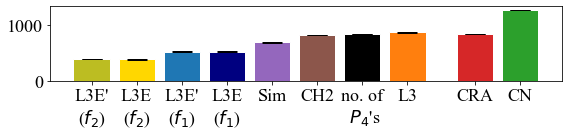

In [9]:
# calculate AUC
def AUC_plot(auc_map):
    mean_auc, std_auc = {}, {}
    for method in auc_map:
        mean_auc[method] = np.mean(auc_map[method])
        std_auc[method] = np.std(auc_map[method])
    
    pos = [0,1,2,3,4,5,6,7,8.5,9.5]
    fig = plt.figure(figsize=(8, 2))
    xtick = [i for i in list(dict(sorted(
        auc_map.items(), key=lambda item: item[1])).keys()) if i not in ['CN', 'CRA']] + ['CRA', 'CN']
    ax = plt.gca()
    ax.bar(pos, [mean_auc[x] for x in xtick], tick_label=[abbrevs[x] for x in xtick]
                      , yerr=[std_auc[x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='white', capsize=10)
    plt.tight_layout()
    plt.savefig('./img_simulation/incomp_AUC_supple.png', dpi=300)
    plt.show()
    
scores = {}
filename = "./simulation_out/incompEdges1.dat"
with open(filename, "rb") as f:
    scores = pickle.loads(f.read())
    
auc_map = defaultdict(list)
for method in ["commonNeighbor", "CRA", "L3Normalizing", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "countP4", "L3E1_f1Alt", "L3E1_f2Alt"]:
    for trial in range(len(scores[method])):
        scores[method][trial] = [1 if math.isnan(x) else x for x in scores[method][trial]]
        smoothed_score = savgol_filter(scores[method][trial], 21, 3)
        x = [i for i in range(len(smoothed_score))]
        minX = np.argmin(np.asarray(smoothed_score))
        auc_map[methods_names[method]].append(metrics.auc(x[minX:], smoothed_score[minX:]))
    
AUC_plot(auc_map)

In [10]:
# p val
pairs = ['L3E1_f2', 'L3E1_f1']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

# p val
pairs = ['L3E1_f2', 'L3E1_f2Alt']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

# p val
pairs = ['L3E1_f1Alt', 'L3E1_f1']
pop1 = auc_map[pairs[0]]
pop2 = auc_map[pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {}: {}".format(pairs[0], pairs[1], pVal))

L3E1_f2 L3E1_f1: 3.658875404993934e-23
L3E1_f2 L3E1_f2Alt: 0.08952012389810983
L3E1_f1Alt L3E1_f1: 0.9239675273134731
